# FEniCS + loading tagged meshes

In [1]:
from dolfinx import default_scalar_type, fem, mesh
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import gmshio
import gmsh
from mpi4py import MPI
import numpy as np
import ufl

## Load previously generated mesh

We load the mesh previously generated.

In [2]:
I, cell_tags, facet_tags = gmshio.read_from_msh("interval.msh", MPI.COMM_WORLD)

Info    : Reading 'interval.msh'...
Info    : 5 entities
Info    : 101 nodes
Info    : 100 elements
Info    : Done reading 'interval.msh'


`I` is the interval mesh.

In [3]:
I

In [4]:
I_x = I.geometry.x[:,0]
I_x

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

`material_tags` contains all the tags defined in the mesh.

In [5]:
material_tags = np.unique(cell_tags.values)
material_tags

array([1, 2], dtype=int32)

## Function space, boundary conditions

We create a function space on the mesh.

In [6]:
V = fem.functionspace(I, ('Lagrange', 1))

In [7]:
dofs_L = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
dofs_R = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 1))
bc_L = fem.dirichletbc(default_scalar_type(0), dofs_L, V)
bc_R = fem.dirichletbc(default_scalar_type(10), dofs_R, V)
bcs = [bc_L, bc_R]

## Functions

In [8]:
u = ufl.TrialFunction(V)
phi = ufl.TestFunction(V)

## Spacially-dependent parameters

In [9]:
sigma = fem.Function(V)
sigma_list = [
    1,  # value for tag 1
    2,  # value for tag 2
]
for tag in material_tags:
    cells = cell_tags.find(tag)
    if tag == 1:
        s_ = sigma_list[0]
    if tag == 2:
        s_ = sigma_list[1]
    sigma.x.array[cells] = np.full_like(cells, s_, dtype=default_scalar_type)

## Solve problem

In [10]:
lhs = ufl.inner(sigma * ufl.grad(u), ufl.grad(phi)) * ufl.dx
rhs = fem.Constant(I, default_scalar_type(0)) * phi * ufl.dx

In [11]:
problem = LinearProblem(lhs, rhs, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
u = problem.solve()

In [12]:
u

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, interval, 1, equispaced, unset, False, float64, []), (3,)), 0), Basix element (P, interval, 1, gll_warped, unset, False, float64, [])), 1)

## Comparison with analytic solution

In [13]:
u_analytic = fem.Function(V)
sol_points = np.where(I_x < 0.5, I_x * 40 / 3, I_x * 20 / 3 + 10 / 3)
u_analytic.x.array[:] = sol_points

In [14]:
L2_error = fem.assemble_scalar(fem.form(ufl.inner(u - u_analytic, u - u_analytic) * ufl.dx))
L2_error

0.0019956819469994277

## Matrix generation

In [15]:
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
a = fem.form(lhs)
A = assemble_matrix(a, bcs=bcs)
A.assemble()

In [16]:
from scipy.sparse import csr_matrix
csr = csr_matrix(A.getValuesCSR()[::-1], shape=A.size)
print(csr.toarray())

[[   1.    0.    0. ...    0.    0.    0.]
 [   0.  200. -100. ...    0.    0.    0.]
 [   0. -100.  200. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...  400. -200.    0.]
 [   0.    0.    0. ... -200.  300.    0.]
 [   0.    0.    0. ...    0.    0.    1.]]


In [17]:
b = create_vector(fem.form(rhs))
apply_lifting(b, [fem.form(a)], [bcs])
set_bc(b, bcs)
b.array

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
       1000.,   10.])

In [18]:
err = csr.toarray() @ u.x.array - b.array
np.linalg.norm(err)

np.float64(2.2733953352188767e-12)

## Plotting

In [20]:
u.x.array[49:52]

array([6.51884701, 6.6075388 , 6.67405765])

In [21]:
sol_points[49:52]

array([6.53333333, 6.66666667, 6.73333333])

In [22]:
u.x.array

array([ 0.        ,  0.13303769,  0.26607539,  0.39911308,  0.53215078,
        0.66518847,  0.79822616,  0.93126386,  1.06430155,  1.19733925,
        1.33037694,  1.46341463,  1.59645233,  1.72949002,  1.86252772,
        1.99556541,  2.1286031 ,  2.2616408 ,  2.39467849,  2.52771619,
        2.66075388,  2.79379157,  2.92682927,  3.05986696,  3.19290466,
        3.32594235,  3.45898004,  3.59201774,  3.72505543,  3.85809313,
        3.99113082,  4.12416851,  4.25720621,  4.3902439 ,  4.5232816 ,
        4.65631929,  4.78935698,  4.92239468,  5.05543237,  5.18847007,
        5.32150776,  5.45454545,  5.58758315,  5.72062084,  5.85365854,
        5.98669623,  6.11973392,  6.25277162,  6.38580931,  6.51884701,
        6.6075388 ,  6.67405765,  6.7405765 ,  6.80709534,  6.87361419,
        6.94013304,  7.00665188,  7.07317073,  7.13968958,  7.20620843,
        7.27272727,  7.33924612,  7.40576497,  7.47228381,  7.53880266,
        7.60532151,  7.67184035,  7.7383592 ,  7.80487805,  7.87

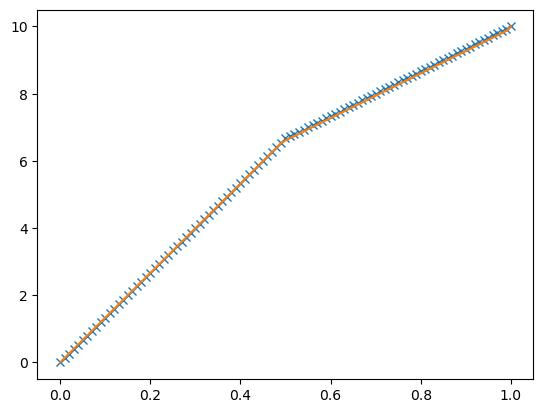

In [23]:
import matplotlib.pyplot as plt

plt.plot(I_x, sol_points, 'x')
plt.plot(I_x, u.x.array)

## Save output files

In [24]:
import dolfinx
with dolfinx.io.VTXWriter(MPI.COMM_WORLD, "./u_sol.bp", [u], engine="BP4") as vtx:
    vtx.write(0.0)

In [25]:
from dolfinx import io
with io.XDMFFile(I.comm, "./u.xdmf", "w") as xdmf:
    xdmf.write_mesh(I)
    xdmf.write_function(u)